## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [6]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping
import itertools
results = {}

MONITOR = ["val_loss", "val_accuracy"]
PATIENCE = [10, 25]

for monitor, patience in itertools.product(MONITOR, PATIENCE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Monitor: {monitor}, Patience epochs: {patience}")
    earlystop = EarlyStopping(monitor=monitor, 
                              patience=patience, 
                              verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
              )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Monitor: {monitor}, Patience epochs: {patience}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Monitor: val_loss, Patience epochs: 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)

Epoch 13/50
196/196 [==============================] - 5s 25ms/step - loss: 0.9818 - accuracy: 0.6619 - val_loss: 1.4612 - val_accuracy: 0.5033
Epoch 14/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9479 - accuracy: 0.6745 - val_loss: 1.5495 - val_accuracy: 0.4837
Epoch 15/50
196/196 [==============================] - 5s 26ms/step - loss: 0.9135 - accuracy: 0.6848 - val_loss: 1.5394 - val_accuracy: 0.4780
Epoch 16/50
196/196 [==============================] - 5s 26ms/step - loss: 0.8801 - accuracy: 0.6983 - val_loss: 1.5316 - val_accuracy: 0.4857
Epoch 17/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8455 - accuracy: 0.7120 - val_loss: 1.5639 - val_accuracy: 0.4815
Epoch 18/50
196/196 [==============================] - 5s 27ms/step - loss: 0.8164 - accuracy: 0.7227 - val_loss: 1.6362 - val_accuracy: 0.4741
Epoch 19/50
196/196 [==============================] - 5s 25ms/step - loss: 0.7849 - accuracy: 0.7317 - val_loss: 1.5867 - val_accuracy:

Epoch 22: early stopping
Monitor: val_accuracy, Patience epochs: 25
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                           

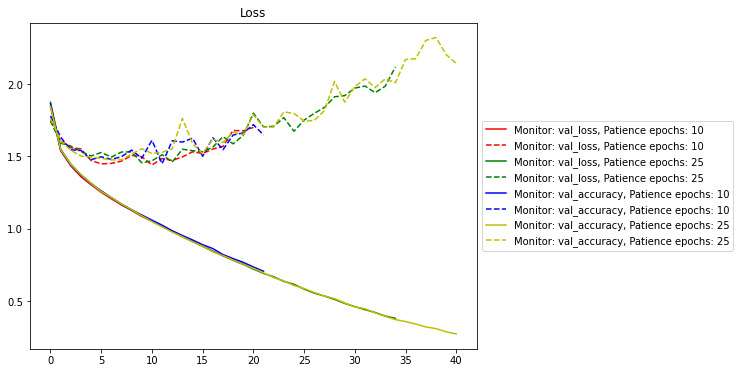

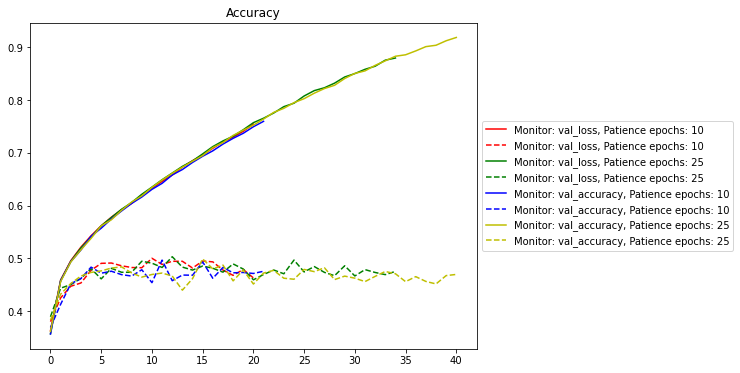

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 筆記
1. Monitor 使用 val_loss or val_accuracy 差不多
2. 使用 Early stop, 避免 overfiiting 但模型泛化能力沒有更好, 所以 Patience 好像可以取少一點